# Projeto 1 - Ciência dos Dados

Nome: Bruno Schmitt Locatelli

Nome: Julia Diniz do Nascimento

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
### Carregando algumas bibliotecas:

In [58]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import nltk
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [59]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\julia\Desktop\CDados\22-2a-cd-p1-grupo_brunosl2\data


### Funções Importantes:

In [60]:
def cleanup(text):
    punctuation = '[!-.:?;()"''@/\%$&<>,*^´`ª]'
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed.lower()

def stopwords(list_of_words):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    listafinal = []
    for word in list_of_words:
        if word not in stopwords:
            listafinal.append(word)
    return listafinal

Carregando a base de dados com as notícias classificadas manualmente:

In [61]:
path = os.chdir(r"..\data")

In [62]:
filename = (f'dados.xlsx')

In [63]:
train = pd.read_excel(filename, sheet_name = 'Treinamento')

In [64]:
test = pd.read_excel(filename, sheet_name = 'Teste')

___
## Classificador automático


### Descrição do assuntos e o que foi considerado como positivo ou negativo nas notícias (Target).


O assunto abordado nesse projeto foi *agronegócio* e duas targets foram utilizadas para classificar as notícias:
- positivo:
    notícias com foco em crescimento do agronegócio, expansão de plantações, liberação de importação e exportação, aumento de safras...
    
- negativo
    notícias com números negativos, descrescimento de safras, de áreas verdes, desmatamento, bloqueios internacionais...

### Targets:

In [65]:
dados_negativos = train.loc[ train['Target']==1, ['Titulo'] ]
dados_negativos.count()

Titulo    129
dtype: int64

In [66]:
dados_positivos = train.loc[ train['Target']==2, ['Titulo'] ]
dados_positivos.count()

Titulo    174
dtype: int64

### Transformando as bases em string:

In [67]:
titulo_negativos = dados_negativos['Titulo']
str_negativos = ''

for frase_neg in titulo_negativos:
    str_negativos += cleanup(frase_neg) + ' '
    
palavras_negativos = stopwords(str_negativos.split())

In [68]:
titulo_positivos = dados_positivos['Titulo']
str_positivos = ''

for frase_p in titulo_positivos:
    str_positivos += cleanup(frase_p) + ' '
    
palavras_positivos = stopwords(str_positivos.split())

In [69]:
serie_negativos = pd.Series(palavras_negativos)

#tabelas
tabela_n = serie_negativos.value_counts(normalize=True)
tabela_n_absoluta = serie_negativos.value_counts()


In [70]:
serie_positivos = pd.Series(palavras_positivos)

#tabelas
tabela_p = serie_negativos.value_counts(normalize=True)
tabela_p_absoluta = serie_positivos.value_counts()


In [71]:
str_total = str_negativos + str_positivos

palavras_total = stopwords(str_total.split())

serie_total = pd.Series(palavras_total)

#tabelas
tabela_t = serie_total.value_counts(normalize=True)
tabela_t_absoluta = serie_total.value_counts()

In [72]:
#prob a priori

prob_n = len(str_negativos)/len(str_total)

prob_p = len(str_positivos)/len(str_total)

print(prob_n + prob_p)

1.0


___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [73]:
def laplace(palavra, tabela_abs, tabela_abs_total):
    if palavra not in tabela_abs:
        prob_palavra_dado_categoria = 1 / ( len(tabela_abs_total) + sum(tabela_abs) )
    else: 
        prob_palavra_dado_categoria = ( tabela_abs[palavra] + 1 ) / ( len(tabela_abs_total) + sum(tabela_abs) )
    
    return prob_palavra_dado_categoria

In [74]:
def classificador(test):    
    lista_classificacao = []
    for titulo in test.Titulo:

        titulo = cleanup(titulo)
        palavras = stopwords(titulo.split())

        prob_p_dado_noticia = 1
        prob_n_dado_noticia = 1

        #repetição para aplicar laplace em todos os titulos
        for palavra in palavras:
            prob_p_dado_noticia = prob_p_dado_noticia * laplace(palavra, tabela_p_absoluta, tabela_t)

            prob_n_dado_noticia = prob_n_dado_noticia * laplace(palavra, tabela_n_absoluta, tabela_t)

        #multiplicação das probabilidades a priori
        prob_p_dado_noticia *= prob_p

        prob_n_dado_noticia *= prob_n


        #condições para classificação das probabilidades calculadas anteriormente
        if prob_n_dado_noticia > prob_p_dado_noticia:
            lista_classificacao.append('Negativo')
        elif prob_p_dado_noticia > prob_n_dado_noticia:
            lista_classificacao.append('Positivo')

    #Adicionando a lista de classificação no dataframe, com uma coluna nova chamada 'Classificado_titulo'
    classificacao = pd.Series(lista_classificacao)
    test['Classificado_titulo'] = classificacao
    return test

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

### Tabela de frequência absoluta:

In [75]:
teste = classificador(test)

tabela_abs = pd.crosstab(test['Target'], test['Classificado_titulo'])
tabela_abs

Classificado_titulo,Negativo,Positivo
Target,,
1,54,20
2,39,92


### Tabela de frequência relativa

In [76]:
tabela_rel = pd.crosstab(test['Target'], test['Classificado_titulo'], normalize = 'index')
tabela_rel

Classificado_titulo,Negativo,Positivo
Target,,
1,0.72973,0.27027
2,0.29771,0.70229


In [77]:
#negativos
verdadeiros_negativos = tabela_rel.iloc[0, 0] * 100
falsos_negativos = tabela_rel.iloc[0, 1] * 100

#positivos
verdadeiros_positivos = tabela_rel.iloc[1, 1] * 100
falsos_positivos = tabela_rel.iloc[1, 0] * 100

In [78]:
# acurácia:
vdd_neg_abs = tabela_abs.iloc[0, 0]
vdd_pos_abs = tabela_abs.iloc[1, 1]

acc = ((vdd_neg_abs + vdd_pos_abs)* 100 ) / len(test)

In [79]:

print(f'A porcentagem de verdadeiros negativos é:{verdadeiros_negativos:.3f}')
print(f'A porcentagem de verdadeiros positivos é: {verdadeiros_positivos: .3f}')
print(f'Acurácia do modelo: {acc: .3f}')

A porcentagem de verdadeiros negativos é:72.973
A porcentagem de verdadeiros positivos é:  70.229
Acurácia do modelo:  71.220


___
### Concluindo

Após descobrir a quantidade de acertos nos dois targets defininos (positivo e negativo), foi possível calcular a eficácia do classificador que foi de 71,2%. Essa porcentagem pode ser considerada muito satisfátoria nesse cenário, porque ela é maior que um chute aleatório entre as duas categorias do Target, que seria de 50%. Porém, mesmo essa acurácia satisfátoria, o classificador ainda possui algumas ingenuidades em relação a palavras de duplo sentido, sarcasmo e ironia, porque trata as palavras como independentes.


#### Possíveis melhorias:

- Não tratar as palavras como independentes, dando valor à ordem em que está situada na frase.
- Aumento dos Targets em sugcategorias como: *Marketing*, *Soja*, *Tratores*, *Exportação*, ...

#### Possíveis aplicações:

Levando em consideração a ingenuidade do classificador quanto a ordem das palavras, ele seria bem utilizado para propósitos de *palavras-chave*, como em plataformas de streaming e sites de busca, com o intuíto de sugerir anúncios ou videos e sites parecidos com palavras procuradas anteriormente pelo usuário.

___
### Qualidade do Classificador a partir de novas separações das notícias entre Treinamento e Teste

In [84]:
test2 = pd.read_excel(filename, sheet_name = 'Teste')

train2 = pd.read_excel(filename, sheet_name = 'Treinamento')

tudo = pd.concat([test2, train2])
dataframe_tudo = pd.DataFrame(tudo)

In [81]:
lista_eficacia = []

for i in range(200):
    train2,test2 = train_test_split(tudo, test_size=300)
    
    train_negativo = train2.loc[train2['Target']==1,:]
    train_positivo = train2.loc[train2['Target']==2,:]
    
    
    titulos_positivos = list(train_positivo['Titulo'])
    titulos_negativos = list(train_negativo['Titulo'])
    
    palavrastitulos_negativos = stopwords(' '.join(titulos_negativos).split())
    palavrastitulos_positivos = stopwords(' '.join(titulos_positivos).split())
    
    titulos_tudo = palavrastitulos_negativos + palavrastitulos_positivos
    
    serienegativa = pd.Series(palavrastitulos_negativos)
    seriepositiva = pd.Series(palavrastitulos_positivos)
    
    serie_tudo = pd.Series(titulos_tudo)
    
    tabela_n_absoluta2 = serienegativa.value_counts()
    tabela_p_absoluta2 = seriepositiva.value_counts()
    
    tabela_t2 = serie_total.value_counts()
    
    #prob priori
    prob_p2 = len(palavrastitulos_positivos) / len(titulos_tudo)
    prob_neg2 = len(palavrastitulos_negativos) / len(titulos_tudo)
    


    def classificador2(test):    
        lista_classificacao2 = []
        for titulo2 in test.Titulo:

            titulo2 = cleanup(titulo2)
            palavras2 = stopwords(titulo2.split())

            prob_p_dado_noticia2 = 1
            prob_n_dado_noticia2 = 1

            #repetição para aplicar laplace em todos os titulos
            for palavra2 in palavras2:
                prob_p_dado_noticia2 = prob_p_dado_noticia2 * laplace(palavra2, tabela_p_absoluta2, tabela_t2)

                prob_n_dado_noticia2 = prob_n_dado_noticia2 * laplace(palavra2, tabela_n_absoluta2, tabela_t2)

            #multiplicação das probabilidades a priori
            prob_p_dado_noticia2 *= prob_p

            prob_n_dado_noticia2 *= prob_n


            #condições para classificação das probabilidades calculadas anteriormente
            if prob_n_dado_noticia2 > prob_p_dado_noticia2:
                lista_classificacao2.append('Negativo')
            elif prob_p_dado_noticia2 > prob_n_dado_noticia2:
                lista_classificacao2.append('Positivo')

        #Adicionando a lista de classificação no dataframe, com uma coluna nova chamada 'Classificado_titulo'
        classificacao2 = pd.Series(lista_classificacao2)
        test['Classificado_titulo'] = classificacao2
        return test2
    
    resultado2 = classificador2(test2)
    
    tabela2 = pd.crosstab(resultado2['Target'], resultado2['Classificado_titulo'])
    
    efic_titulo2 = (tabela2.iloc[0,0] + tabela2.iloc[1,1])*100 / len(resultado2)
    
    lista_eficacia.append(efic_titulo2)


In [85]:
lista_eficacia2 = pd.Series(lista_eficacia)
print(f'A menor acurácia foi de {lista_eficacia2.min() :.3f}%')
print(f'A maior acurácia foi de {lista_eficacia2.max() : .3f}% ')
print(f'A média de acurácia foi de {lista_eficacia2.mean(): .3f}%')

A menor acurácia foi de 38.667%
A maior acurácia foi de  58.333% 
A média de acurácia foi de  49.338%


### Histograma:

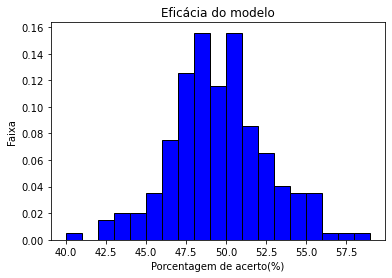

In [86]:
faixas = np.arange(40, 60, 1)
plt.hist(lista_eficacia, bins=faixas, edgecolor='black', color = 'blue', density = True)
plt.title('Eficácia do modelo')
plt.ylabel('Faixa')
plt.xlabel('Porcentagem de acerto(%)')
plt.show()

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nas notícias. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas caterogias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por caterogia (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**